# GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Jan  8 03:11:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# CFG

In [3]:
CONFIG_NAME = 'config05.yml'
TITLE = '05t-resnet50'

In [4]:
! git clone https://github.com/raijin0704/cassava.git
# ====================================================
# CFG
# ====================================================
import yaml

CONFIG_PATH = f'./cassava/config/{CONFIG_NAME}'
with open(CONFIG_PATH) as f:
    config = yaml.load(f)

INFO = config['info']
TAG = config['tag']
CFG = config['cfg']

CFG['train'] = True
CFG['inference'] = False

if CFG['debug']:
    CFG['epochs'] = 1


assert INFO['TITLE'] == TITLE

Cloning into 'cassava'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 47 (delta 27), reused 10 (delta 5), pack-reused 0
Unpacking objects: 100% (47/47), done.


# colab & kaggle notebookでの環境面の処理

## colab

In [5]:
def _colab_kaggle_authority():
    from googleapiclient.discovery import build
    import io, os
    from googleapiclient.http import MediaIoBaseDownload

    drive_service = build('drive', 'v3')
    results = drive_service.files().list(
            q="name = 'kaggle.json'", fields="files(id)").execute()
    kaggle_api_key = results.get('files', [])

    filename = "/root/.kaggle/kaggle.json"
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(filename, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(filename, 600)


def process_colab():
    import subprocess
    
    # ドライブのマウント
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Cloudの権限設定
    from google.colab import auth
    auth.authenticate_user()

    # kaggle設定
    # _colab_kaggle_authority()
    # subprocess.run('pip install --upgrade --force-reinstall --no-deps kaggle'.split(' '))

    # ライブラリ関係
    subprocess.run('pip install --upgrade opencv-python'.split(' '))
    subprocess.run('pip install --upgrade albumentations'.split(' '))
    subprocess.run('pip install timm'.split(' '))

    # 各種pathの設定
    DATA_PATH = '/content/drive/Shareddrives/便利用/kaggle/cassava/input/'
    OUTPUT_DIR = './output/'
    NOTEBOOK_PATH = f'/content/drive/MyDrive/Colab Notebooks/{TITLE}.ipynb'

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## kaggle notebook

In [6]:
def _kaggle_gcp_authority():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    user_credential = user_secrets.get_gcloud_credential()
    user_secrets.set_tensorflow_credential(user_credential)

def process_kaggle():
    # GCP設定
    _kaggle_gcp_authority()

    # 各種pathの設定
    DATA_PATH = '../input/cassava-leaf-disease-classification/'
    OUTPUT_DIR = './'
    NOTEBOOK_PATH = './__notebook__.ipynb'
    # system path
    import sys
    sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

    return DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH

## 共通

In [7]:
def process_common():
    # ライブラリ関係
    import subprocess
    subprocess.run('pip install mlflow'.split(' '))

    # 環境変数
    import os
    os.environ["GCLOUD_PROJECT"] = INFO['PROJECT_ID']

In [8]:
try:
    from google.colab import auth
except ImportError:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_kaggle()
else:
    DATA_PATH, OUTPUT_DIR, NOTEBOOK_PATH = process_colab()
finally:
    process_common()

Mounted at /content/drive


# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import datetime
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm
import mlflow

import warnings 
warnings.filterwarnings('ignore')

if CFG['apex']:
    from apex import amp

if CFG['debug']:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda')
start_time = datetime.datetime.now()
start_time_str = start_time.strftime('%m%d%H%M')

# Directory settings

In [10]:
# ====================================================
# Directory settings
# ====================================================
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# save basic files

In [11]:
# with open(f'{OUTPUT_DIR}/{start_time_str}_TAG.json', 'w') as f:
#     json.dump(TAG, f, indent=4)
    
# with open(f'{OUTPUT_DIR}/{start_time_str}_CFG.json', 'w') as f:
#     json.dump(CFG, f, indent=4)

import shutil
notebook_path = f'{OUTPUT_DIR}/{start_time_str}_{TITLE}.ipynb'
shutil.copy2(NOTEBOOK_PATH, notebook_path)

'./output//01080313_05t-resnet50.ipynb'

# Data Loading

In [12]:
train = pd.read_csv(f'{DATA_PATH}/train.csv')
test = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
label_map = pd.read_json(f'{DATA_PATH}/label_num_to_disease_map.json', 
                         orient='index')

if CFG['debug']:
    train = train.sample(n=1000, random_state=CFG['seed']).reset_index(drop=True)

# Utils

In [13]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger_path = OUTPUT_DIR+f'{start_time_str}_train.log'
LOGGER = init_logger(logger_path)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG['seed'])


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, save_path='checkpoint.pt',
                 counter=0, best_score=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            save_path (str): Directory for saving a model.
                             Default: "'checkpoint.pt'"
        """
        self.patience = patience
        self.verbose = verbose
        self.save_path = save_path
        self.counter = counter
        self.best_score = best_score
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, preds, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, preds, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, preds, epoch):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.10f} --> {val_loss:.10f}).  Saving model ...')
        torch.save({'model': model.state_dict(), 'preds': preds, 
                    'epoch' : epoch, 'best_score' : self.best_score, 'counter' : self.counter},
                   self.save_path)
        self.val_loss_min = val_loss

# CV split

In [14]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG['n_fold'], shuffle=True, random_state=CFG['seed'])
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG['target_col']])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG['target_col']]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [15]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/train_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label
    

class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['image_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{DATA_PATH}/test_images/{file_name}'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

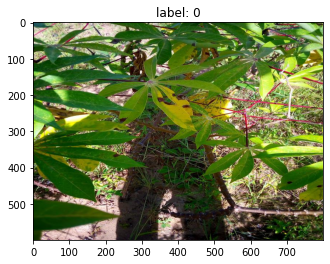

In [17]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f'label: {label}')
    plt.show() 

# Transforms

In [18]:
def _get_augmentations(aug_list):
    process = []
    for aug in aug_list:
        if aug ==  'Resize':
            process.append(Resize(CFG['size'], CFG['size']))
        elif aug == 'RandomResizedCrop':
            process.append(RandomResizedCrop(CFG['size'], CFG['size']))
        elif aug == 'Transpose':
            process.append(Transpose(p=0.5))
        elif aug == 'HorizontalFlip':
            process.append(HorizontalFlip(p=0.5))
        elif aug == 'VerticalFlip':
            process.append(VerticalFlip(p=0.5))
        elif aug == 'ShiftScaleRotate':
            process.append(ShiftScaleRotate(p=0.5))
        elif aug == 'Normalize':
            process.append(Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ))
        else:
            raise ValueError(f'{aug} is not suitable')

    process.append(ToTensorV2())

    return process

In [19]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose(
            _get_augmentations(TAG['augmentation'])
        )

    elif data == 'valid':
        return Compose(
            _get_augmentations(['Resize', 'Normalize'])
        )

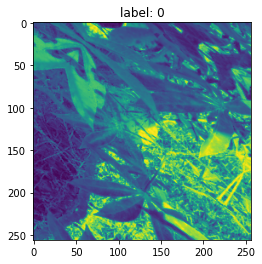

In [20]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# Bi-tempered logistic loss

In [21]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

# MODEL

In [22]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        if hasattr(self.model, 'classifier'):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG['target_size'])
        elif hasattr(self.model, 'fc'):
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG['target_size'])

    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
model = CustomModel(model_name=TAG['model_name'], pretrained=False)
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.1430,  0.2589, -0.0207,  0.0822,  0.1411],
        [ 0.1331,  0.2431,  0.0429,  0.0643,  0.1357],
        [ 0.2025,  0.2250, -0.0176, -0.0446,  0.0595],
        [ 0.1067,  0.3194, -0.0208, -0.0353, -0.0048]],
       grad_fn=<AddmmBackward>)


# Helper functions

In [24]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))




In [25]:
# ====================================================
# loss
# ====================================================
def get_loss(criterion, y_preds, labels):
    if TAG['criterion']=='CrossEntropyLoss':
        loss = criterion(y_preds, labels)
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        loss = criterion(y_preds, labels, t1=CFG['bi_tempered_loss_t1'], t2=CFG['bi_tempered_loss_t2'])
    return loss

In [26]:
# ====================================================
# Helper functions
# ====================================================
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = get_loss(criterion, y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        if CFG['apex']:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG['max_grad_norm'])
        if (step + 1) % CFG['gradient_accumulation_steps'] == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  #'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   #lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = get_loss(criterion, y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        if CFG['gradient_accumulation_steps'] > 1:
            loss = loss / CFG['gradient_accumulation_steps']
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG['print_freq'] == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            # model.load_state_dict(state['model'])
            model.load_state_dict(state)
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [27]:
# ====================================================
# scheduler 
# ====================================================
def get_scheduler(optimizer):
    if TAG['scheduler']=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG['factor'], patience=CFG['patience'], verbose=True, eps=CFG['eps'])
    elif TAG['scheduler']=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG['T_max'], eta_min=CFG['min_lr'], last_epoch=-1)
    elif TAG['scheduler']=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    return scheduler

# ====================================================
# criterion
# ====================================================
def get_criterion():
    if TAG['criterion']=='CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif TAG['criterion'] == 'bi_tempered_logistic_loss':
        criterion = bi_tempered_logistic_loss
    return criterion

In [28]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")
    if not CFG['debug']:
        mlflow.set_tag('running.fold', str(fold))
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=True, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG['batch_size'], 
                              shuffle=False, 
                              num_workers=CFG['num_workers'], pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer & criterion
    # ====================================================
    model = CustomModel(TAG['model_name'], pretrained=True)
    model.to(device)
    # 学習途中の重みがあれば読み込み
    if os.path.isfile(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth'):
        state = torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth')
        model.load_state_dict(state['model'])
        epoch_start = state['epoch']+1
        er_best_score = state['best_score']
        er_counter = state['counter']
        # epoch_start = 10
        # er_best_score = 0
        # er_counter = 1
        LOGGER.info(f'Retrain model in epoch:{epoch_start}, best_score:{er_best_score:.3f}, counter:{er_counter}')
    else:
        epoch_start = 0
        er_best_score = None
        er_counter = 0

    optimizer = Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'], amsgrad=False)
    scheduler = get_scheduler(optimizer)
    criterion = get_criterion()

    # ====================================================
    # apex
    # ====================================================
    if CFG['apex']:
        model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)

    # ====================================================
    # loop
    # ====================================================
    # best_score = 0.
    # best_loss = np.inf
    
    early_stopping = EarlyStopping(
                            patience=CFG['early_stopping_round'], 
                            verbose=True,
                            save_path=OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth',
                            counter=er_counter, best_score=er_best_score)
    
    for epoch in range(epoch_start, CFG['epochs']):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG['target_col']].values
        
        # early stopping
        early_stopping(avg_val_loss, model, preds, epoch)
        if early_stopping.early_stop:
            print(f'Epoch {epoch+1} - early stopping')
            break
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric(f"fold{fold} avg_train_loss", avg_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} avg_valid_loss", avg_val_loss, step=epoch)
            mlflow.log_metric(f"fold{fold} score", score, step=epoch)
            mlflow.log_metric(f"fold{fold} lr", scheduler.get_last_lr()[0], step=epoch)
            mlflow.log_artifact(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(5)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds

In [29]:
# ====================================================
# main
# ====================================================
def get_result(result_df):
    preds = result_df['preds'].values
    labels = result_df[CFG['target_col']].values
    score = get_score(labels, preds)
    LOGGER.info(f'Score: {score:<.5f}')
    
    return score

    

def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """
    
    if CFG['train']:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG['n_fold']):
            if fold in CFG['trn_fold']:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                _ = get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        score = get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        # log mlflow
        if not CFG['debug']:
            mlflow.log_metric('oof score', score)
            mlflow.delete_tag('running.fold')
            mlflow.log_artifact(OUTPUT_DIR+'oof_df.csv')
    
    if CFG['inference']:
        # inference
        model = CustomModel(TAG['model_name'], pretrained=False)
        states = [torch.load(OUTPUT_DIR+f'{TAG["model_name"]}_fold{fold}_best.pth') for fold in CFG['trn_fold']]
        test_dataset = TestDataset(test, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG['batch_size'], shuffle=False, 
                                 num_workers=CFG['num_workers'], pin_memory=True)
        predictions = inference(model, states, test_loader, device)
        # submission
        test['label'] = predictions.argmax(1)
        test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

# rerun

In [32]:
def _load_save_point(run_id):
    # どこで中断したか取得
    # stop_fold = int(mlflow.get_run(run_id=run_id).to_dictionary()['data']['tags']['running.fold'])
    stop_fold = 4
    # 学習対象のfoldを変更
    CFG['trn_fold'] = [fold for fold in CFG['trn_fold'] if fold>=stop_fold]
    # 学習済みモデルがあれば.pthファイルを取得(学習中も含む)
    client = mlflow.tracking.MlflowClient()
    artifacts = [artifact for artifact in client.list_artifacts(run_id) if ".pth" in artifact.path]
    for artifact in artifacts:
        client.download_artifacts(run_id, artifact.path, OUTPUT_DIR)


def check_have_run():
    results = mlflow.search_runs(INFO['EXPERIMENT_ID'])
    run_id_list = results[results['tags.mlflow.runName']==TITLE]['run_id'].tolist()
    # 初めて実行する場合
    if len(run_id_list) == 0:
        run_id = None
    # 既に実行されている場合
    else:
        assert len(run_id_list)==1
        run_id = run_id_list[0]
        _load_save_point(run_id)

    return run_id

In [ ]:
if __name__ == '__main__':
    if CFG['debug']:
        main()
    else:
        mlflow.set_tracking_uri(INFO['TRACKING_URI'])
        mlflow.set_experiment('single model')
        # 既に実行済みの場合は続きから実行する
        run_id = check_have_run()
        with mlflow.start_run(run_id=run_id, run_name=TITLE):
            if run_id is None:
                mlflow.log_artifact(CONFIG_PATH)
                mlflow.log_param('device', device)
                mlflow.set_tags(TAG)
                mlflow.log_params(CFG)
            mlflow.log_artifact(notebook_path)
            main()
            mlflow.log_artifacts(OUTPUT_DIR)

========== fold: 4 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


Epoch: [1][0/534] Data 14.114 (14.114) Elapsed 0m 14s (remain 130m 48s) Loss: 0.5136(0.5136) Grad: 0.9786  
Epoch: [1][100/534] Data 9.513 (3.102) Elapsed 6m 1s (remain 25m 48s) Loss: 0.1833(0.2801) Grad: 1.7172  
Epoch: [1][200/534] Data 0.000 (3.028) Elapsed 11m 46s (remain 19m 30s) Loss: 0.2012(0.2402) Grad: 1.7732  
Epoch: [1][300/534] Data 0.000 (2.995) Elapsed 17m 28s (remain 13m 31s) Loss: 0.1739(0.2220) Grad: 2.3563  
Epoch: [1][400/534] Data 0.000 (3.004) Elapsed 23m 19s (remain 7m 44s) Loss: 0.2294(0.2122) Grad: 1.7691  
Epoch: [1][500/534] Data 0.000 (2.981) Elapsed 28m 58s (remain 1m 54s) Loss: 0.1417(0.2036) Grad: 1.3916  
Epoch: [1][533/534] Data 0.000 (2.969) Elapsed 30m 46s (remain 0m 0s) Loss: 0.2222(0.2015) Grad: 1.4540  
EVAL: [0/134] Data 14.303 (14.303) Elapsed 0m 14s (remain 32m 5s) Loss: 0.2120(0.2120) 
EVAL: [100/134] Data 12.363 (3.358) Elapsed 5m 53s (remain 1m 55s) Loss: 0.1677(0.1533) 
EVAL: [133/134] Data 0.000 (3.302) Elapsed 7m 41s (remain 0m 0s) Loss: 0.

Epoch 1 - avg_train_loss: 0.2015  avg_val_loss: 0.1525  time: 2308s
Epoch 1 - Accuracy: 0.8254265015190465


Epoch: [2][0/534] Data 1.440 (1.440) Elapsed 0m 2s (remain 18m 5s) Loss: 0.1734(0.1734) Grad: 1.8962  
Epoch: [2][100/534] Data 0.000 (0.014) Elapsed 0m 50s (remain 3m 37s) Loss: 0.1937(0.1590) Grad: 1.9959  
Epoch: [2][200/534] Data 0.000 (0.007) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1877(0.1592) Grad: 1.6499  
Epoch: [2][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 53s) Loss: 0.2065(0.1611) Grad: 1.1968  
Epoch: [2][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.0945(0.1585) Grad: 0.8922  
Epoch: [2][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1674(0.1576) Grad: 1.3816  
Epoch: [2][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1062(0.1569) Grad: 1.1190  
EVAL: [0/134] Data 1.259 (1.259) Elapsed 0m 1s (remain 3m 4s) Loss: 0.1514(0.1514) 
EVAL: [100/134] Data 0.704 (0.189) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1546(0.1378) 
EVAL: [133/134] Data 0.000 (0.180) Elapsed 0m 41s (remain 0m 0s) Loss: 0.1214(0.1353) 
Valid

Epoch 2 - avg_train_loss: 0.1569  avg_val_loss: 0.1353  time: 301s
Epoch 2 - Accuracy: 0.8506660434681


Epoch: [3][0/534] Data 1.497 (1.497) Elapsed 0m 2s (remain 18m 38s) Loss: 0.2881(0.2881) Grad: 0.9964  
Epoch: [3][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 36s) Loss: 0.0903(0.1482) Grad: 0.7566  
Epoch: [3][200/534] Data 0.000 (0.008) Elapsed 1m 38s (remain 2m 43s) Loss: 0.0779(0.1458) Grad: 1.1678  
Epoch: [3][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 53s) Loss: 0.0943(0.1462) Grad: 0.9403  
Epoch: [3][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1154(0.1469) Grad: 1.0198  
Epoch: [3][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1383(0.1459) Grad: 1.2433  
Epoch: [3][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1478(0.1462) Grad: 1.3118  
EVAL: [0/134] Data 1.208 (1.208) Elapsed 0m 1s (remain 2m 57s) Loss: 0.1671(0.1671) 
EVAL: [100/134] Data 0.544 (0.189) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1585(0.1348) 
EVAL: [133/134] Data 0.025 (0.181) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0687(0.1332) 
Val

Epoch 3 - avg_train_loss: 0.1462  avg_val_loss: 0.1332  time: 301s
Epoch 3 - Accuracy: 0.851600841318065


Epoch: [4][0/534] Data 1.261 (1.261) Elapsed 0m 1s (remain 16m 57s) Loss: 0.1456(0.1456) Grad: 1.0385  
Epoch: [4][100/534] Data 0.000 (0.013) Elapsed 0m 50s (remain 3m 36s) Loss: 0.0957(0.1318) Grad: 1.1236  
Epoch: [4][200/534] Data 0.000 (0.007) Elapsed 1m 38s (remain 2m 43s) Loss: 0.0962(0.1368) Grad: 0.8487  
Epoch: [4][300/534] Data 0.000 (0.004) Elapsed 2m 27s (remain 1m 53s) Loss: 0.1466(0.1369) Grad: 1.5233  
Epoch: [4][400/534] Data 0.000 (0.003) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1430(0.1366) Grad: 1.0467  
Epoch: [4][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1115(0.1370) Grad: 0.9829  
Epoch: [4][533/534] Data 0.000 (0.003) Elapsed 4m 18s (remain 0m 0s) Loss: 0.1479(0.1369) Grad: 1.2998  
EVAL: [0/134] Data 1.373 (1.373) Elapsed 0m 1s (remain 3m 19s) Loss: 0.1553(0.1553) 
EVAL: [100/134] Data 0.726 (0.187) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1698(0.1278) 
EVAL: [133/134] Data 0.000 (0.178) Elapsed 0m 41s (remain 0m 0s) Loss: 0.1365(0.1260) 
Val

Epoch 4 - avg_train_loss: 0.1369  avg_val_loss: 0.1260  time: 300s
Epoch 4 - Accuracy: 0.8530030380930124


Epoch: [5][0/534] Data 1.171 (1.171) Elapsed 0m 1s (remain 16m 8s) Loss: 0.1264(0.1264) Grad: 1.4124  
Epoch: [5][100/534] Data 0.000 (0.012) Elapsed 0m 50s (remain 3m 37s) Loss: 0.0767(0.1302) Grad: 0.9450  
Epoch: [5][200/534] Data 0.000 (0.006) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1172(0.1294) Grad: 1.2391  
Epoch: [5][300/534] Data 0.000 (0.004) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0756(0.1295) Grad: 0.8447  
Epoch: [5][400/534] Data 0.000 (0.003) Elapsed 3m 15s (remain 1m 4s) Loss: 0.0763(0.1320) Grad: 1.0415  
Epoch: [5][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1811(0.1310) Grad: 1.0858  
Epoch: [5][533/534] Data 0.000 (0.002) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0971(0.1314) Grad: 0.9911  
EVAL: [0/134] Data 1.356 (1.356) Elapsed 0m 1s (remain 3m 17s) Loss: 0.1594(0.1594) 
EVAL: [100/134] Data 0.727 (0.189) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1549(0.1166) 
EVAL: [133/134] Data 0.000 (0.183) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0935(0.1174) 
Vali

Epoch 5 - avg_train_loss: 0.1314  avg_val_loss: 0.1174  time: 302s
Epoch 5 - Accuracy: 0.8709978967048376


Epoch: [6][0/534] Data 1.506 (1.506) Elapsed 0m 2s (remain 19m 0s) Loss: 0.1087(0.1087) Grad: 1.1410  
Epoch: [6][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 37s) Loss: 0.2037(0.1219) Grad: 1.3461  
Epoch: [6][200/534] Data 0.000 (0.008) Elapsed 1m 38s (remain 2m 43s) Loss: 0.1634(0.1262) Grad: 1.3139  
Epoch: [6][300/534] Data 0.000 (0.005) Elapsed 2m 26s (remain 1m 53s) Loss: 0.0840(0.1276) Grad: 0.6832  
Epoch: [6][400/534] Data 0.000 (0.004) Elapsed 3m 14s (remain 1m 4s) Loss: 0.1063(0.1283) Grad: 1.2613  
Epoch: [6][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1020(0.1283) Grad: 0.8533  
Epoch: [6][533/534] Data 0.000 (0.003) Elapsed 4m 18s (remain 0m 0s) Loss: 0.2246(0.1287) Grad: 1.3724  
EVAL: [0/134] Data 1.311 (1.311) Elapsed 0m 1s (remain 3m 11s) Loss: 0.1296(0.1296) 
EVAL: [100/134] Data 0.000 (0.187) Elapsed 0m 31s (remain 0m 10s) Loss: 0.1534(0.1214) 


Epoch 6 - avg_train_loss: 0.1287  avg_val_loss: 0.1193  time: 300s
Epoch 6 - Accuracy: 0.8651554101425567


EVAL: [133/134] Data 0.000 (0.181) Elapsed 0m 41s (remain 0m 0s) Loss: 0.1132(0.1193) 
EarlyStopping counter: 1 out of 15
Epoch: [7][0/534] Data 1.511 (1.511) Elapsed 0m 2s (remain 18m 53s) Loss: 0.0984(0.0984) Grad: 1.2158  
Epoch: [7][100/534] Data 0.000 (0.015) Elapsed 0m 51s (remain 3m 39s) Loss: 0.1319(0.1159) Grad: 1.2454  
Epoch: [7][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1510(0.1157) Grad: 0.8567  
Epoch: [7][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1229(0.1167) Grad: 1.1981  
Epoch: [7][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1709(0.1176) Grad: 1.2093  
Epoch: [7][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1108(0.1176) Grad: 1.4137  
Epoch: [7][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1623(0.1183) Grad: 0.9577  
EVAL: [0/134] Data 1.319 (1.319) Elapsed 0m 1s (remain 3m 11s) Loss: 0.1458(0.1458) 
EVAL: [100/134] Data 0.674 (0.193) Elapsed 0m 32s (remai

Epoch 7 - avg_train_loss: 0.1183  avg_val_loss: 0.1165  time: 302s
Epoch 7 - Accuracy: 0.8707641972423463


Epoch: [8][0/534] Data 1.453 (1.453) Elapsed 0m 2s (remain 18m 30s) Loss: 0.1048(0.1048) Grad: 1.5414  
Epoch: [8][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 38s) Loss: 0.1067(0.1085) Grad: 1.1791  
Epoch: [8][200/534] Data 0.000 (0.007) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1740(0.1121) Grad: 1.5327  
Epoch: [8][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0833(0.1111) Grad: 0.8309  
Epoch: [8][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1277(0.1112) Grad: 1.6399  
Epoch: [8][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1881(0.1128) Grad: 1.4674  
Epoch: [8][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1577(0.1123) Grad: 1.6362  
EVAL: [0/134] Data 1.403 (1.403) Elapsed 0m 1s (remain 3m 23s) Loss: 0.1262(0.1262) 
EVAL: [100/134] Data 0.000 (0.191) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1616(0.1144) 
EVAL: [133/134] Data 0.000 (0.182) Elapsed 0m 41s (remain 0m 0s) Loss: 0.1079(0.1139) 
Val

Epoch 8 - avg_train_loss: 0.1123  avg_val_loss: 0.1139  time: 302s
Epoch 8 - Accuracy: 0.8726337929422763


Epoch: [9][0/534] Data 1.395 (1.395) Elapsed 0m 2s (remain 17m 48s) Loss: 0.1390(0.1390) Grad: 1.2218  
Epoch: [9][100/534] Data 0.000 (0.014) Elapsed 0m 50s (remain 3m 37s) Loss: 0.0815(0.1102) Grad: 1.2129  
Epoch: [9][200/534] Data 0.000 (0.007) Elapsed 1m 38s (remain 2m 43s) Loss: 0.1110(0.1085) Grad: 0.7646  
Epoch: [9][300/534] Data 0.000 (0.005) Elapsed 2m 26s (remain 1m 53s) Loss: 0.0782(0.1120) Grad: 1.3323  
Epoch: [9][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1247(0.1107) Grad: 1.4095  
Epoch: [9][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.0653(0.1108) Grad: 1.4495  
Epoch: [9][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1380(0.1108) Grad: 1.2273  
EVAL: [0/134] Data 1.565 (1.565) Elapsed 0m 1s (remain 3m 44s) Loss: 0.1224(0.1224) 
EVAL: [100/134] Data 0.468 (0.189) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1646(0.1108) 
EVAL: [133/134] Data 0.000 (0.182) Elapsed 0m 41s (remain 0m 0s) Loss: 0.1000(0.1107) 
Val

Epoch 9 - avg_train_loss: 0.1108  avg_val_loss: 0.1107  time: 301s
Epoch 9 - Accuracy: 0.8768403832671184


Epoch: [10][0/534] Data 1.544 (1.544) Elapsed 0m 2s (remain 19m 13s) Loss: 0.1311(0.1311) Grad: 0.9852  
Epoch: [10][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 37s) Loss: 0.1241(0.1047) Grad: 1.1591  
Epoch: [10][200/534] Data 0.000 (0.008) Elapsed 1m 38s (remain 2m 43s) Loss: 0.1597(0.1103) Grad: 1.4326  
Epoch: [10][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 53s) Loss: 0.0606(0.1067) Grad: 1.0694  
Epoch: [10][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.2173(0.1073) Grad: 1.4983  
Epoch: [10][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1188(0.1081) Grad: 1.6773  
Epoch: [10][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1241(0.1072) Grad: 1.0993  
EVAL: [0/134] Data 1.314 (1.314) Elapsed 0m 1s (remain 3m 11s) Loss: 0.1232(0.1232) 
EVAL: [100/134] Data 0.835 (0.197) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1693(0.1113) 


Epoch 10 - avg_train_loss: 0.1072  avg_val_loss: 0.1109  time: 301s
Epoch 10 - Accuracy: 0.8761392848796448


EVAL: [133/134] Data 0.000 (0.183) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0953(0.1109) 
EarlyStopping counter: 1 out of 15
Epoch: [11][0/534] Data 1.430 (1.430) Elapsed 0m 2s (remain 18m 20s) Loss: 0.1172(0.1172) Grad: 1.0198  
Epoch: [11][100/534] Data 0.000 (0.014) Elapsed 0m 50s (remain 3m 36s) Loss: 0.1710(0.1185) Grad: 1.0717  
Epoch: [11][200/534] Data 0.000 (0.007) Elapsed 1m 38s (remain 2m 42s) Loss: 0.0458(0.1260) Grad: 1.1937  
Epoch: [11][300/534] Data 0.000 (0.005) Elapsed 2m 26s (remain 1m 53s) Loss: 0.0538(0.1275) Grad: 0.6161  
Epoch: [11][400/534] Data 0.000 (0.004) Elapsed 3m 14s (remain 1m 4s) Loss: 0.1769(0.1273) Grad: 1.3842  
Epoch: [11][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1753(0.1313) Grad: 1.2572  
Epoch: [11][533/534] Data 0.000 (0.003) Elapsed 4m 18s (remain 0m 0s) Loss: 0.1015(0.1318) Grad: 1.2310  
EVAL: [0/134] Data 1.244 (1.244) Elapsed 0m 1s (remain 3m 2s) Loss: 0.1673(0.1673) 
EVAL: [100/134] Data 0.710 (0.194) Elapsed 0m 32s 

Epoch 11 - avg_train_loss: 0.1318  avg_val_loss: 0.1265  time: 301s
Epoch 11 - Accuracy: 0.8609488198177144


EVAL: [133/134] Data 0.000 (0.182) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0894(0.1265) 
EarlyStopping counter: 2 out of 15
Epoch: [12][0/534] Data 1.312 (1.312) Elapsed 0m 1s (remain 16m 44s) Loss: 0.2906(0.2906) Grad: 1.6378  
Epoch: [12][100/534] Data 0.000 (0.013) Elapsed 0m 50s (remain 3m 37s) Loss: 0.1838(0.1368) Grad: 1.7108  
Epoch: [12][200/534] Data 0.000 (0.007) Elapsed 1m 38s (remain 2m 43s) Loss: 0.1601(0.1370) Grad: 1.4087  
Epoch: [12][300/534] Data 0.000 (0.005) Elapsed 2m 26s (remain 1m 53s) Loss: 0.0888(0.1371) Grad: 1.2314  
Epoch: [12][400/534] Data 0.000 (0.003) Elapsed 3m 14s (remain 1m 4s) Loss: 0.0675(0.1340) Grad: 1.2896  
Epoch: [12][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1194(0.1312) Grad: 0.5310  
Epoch: [12][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1113(0.1310) Grad: 0.8654  
EVAL: [0/134] Data 1.357 (1.357) Elapsed 0m 1s (remain 3m 17s) Loss: 0.1499(0.1499) 
EVAL: [100/134] Data 0.111 (0.189) Elapsed 0m 32s

Epoch 12 - avg_train_loss: 0.1310  avg_val_loss: 0.1281  time: 301s
Epoch 12 - Accuracy: 0.8553400327179248


EVAL: [133/134] Data 0.010 (0.183) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0999(0.1281) 
EarlyStopping counter: 3 out of 15
Epoch: [13][0/534] Data 1.545 (1.545) Elapsed 0m 2s (remain 19m 15s) Loss: 0.0659(0.0659) Grad: 0.8353  
Epoch: [13][100/534] Data 0.000 (0.016) Elapsed 0m 50s (remain 3m 38s) Loss: 0.1072(0.1300) Grad: 1.1939  
Epoch: [13][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1280(0.1325) Grad: 0.9952  
Epoch: [13][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1223(0.1317) Grad: 1.2772  
Epoch: [13][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.1059(0.1297) Grad: 1.2639  
Epoch: [13][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1210(0.1265) Grad: 1.2974  
Epoch: [13][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0497(0.1258) Grad: 0.9027  
EVAL: [0/134] Data 1.422 (1.422) Elapsed 0m 1s (remain 3m 25s) Loss: 0.1229(0.1229) 
EVAL: [100/134] Data 0.374 (0.193) Elapsed 0m 32s

Epoch 13 - avg_train_loss: 0.1258  avg_val_loss: 0.1225  time: 302s
Epoch 13 - Accuracy: 0.8658565085300304


EVAL: [133/134] Data 0.000 (0.183) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0943(0.1225) 
EarlyStopping counter: 4 out of 15
Epoch: [14][0/534] Data 1.388 (1.388) Elapsed 0m 1s (remain 17m 14s) Loss: 0.0787(0.0787) Grad: 1.0304  
Epoch: [14][100/534] Data 0.000 (0.014) Elapsed 0m 50s (remain 3m 37s) Loss: 0.2030(0.1213) Grad: 1.2893  
Epoch: [14][200/534] Data 0.000 (0.007) Elapsed 1m 38s (remain 2m 43s) Loss: 0.0557(0.1208) Grad: 1.0247  
Epoch: [14][300/534] Data 0.000 (0.005) Elapsed 2m 26s (remain 1m 53s) Loss: 0.0712(0.1217) Grad: 0.7224  
Epoch: [14][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1631(0.1227) Grad: 1.7707  
Epoch: [14][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.0897(0.1221) Grad: 1.0241  
Epoch: [14][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1041(0.1225) Grad: 0.8971  
EVAL: [0/134] Data 1.447 (1.447) Elapsed 0m 1s (remain 3m 29s) Loss: 0.1837(0.1837) 
EVAL: [100/134] Data 0.606 (0.193) Elapsed 0m 32s

Epoch 14 - avg_train_loss: 0.1225  avg_val_loss: 0.1211  time: 301s
Epoch 14 - Accuracy: 0.8658565085300304


EVAL: [133/134] Data 0.000 (0.181) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0973(0.1211) 
EarlyStopping counter: 5 out of 15
Epoch: [15][0/534] Data 1.543 (1.543) Elapsed 0m 2s (remain 19m 17s) Loss: 0.0583(0.0583) Grad: 0.6857  
Epoch: [15][100/534] Data 0.000 (0.016) Elapsed 0m 51s (remain 3m 39s) Loss: 0.0356(0.1141) Grad: 0.7277  
Epoch: [15][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0921(0.1208) Grad: 0.8867  
Epoch: [15][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0774(0.1182) Grad: 1.2595  
Epoch: [15][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.1109(0.1185) Grad: 1.3397  
Epoch: [15][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.2110(0.1186) Grad: 1.6880  
Epoch: [15][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.2090(0.1188) Grad: 1.5955  
EVAL: [0/134] Data 1.431 (1.431) Elapsed 0m 1s (remain 3m 27s) Loss: 0.1297(0.1297) 
EVAL: [100/134] Data 0.618 (0.194) Elapsed 0m 32s

Epoch 15 - avg_train_loss: 0.1188  avg_val_loss: 0.1246  time: 302s
Epoch 15 - Accuracy: 0.8593129235802758


EVAL: [133/134] Data 0.000 (0.184) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0900(0.1246) 
EarlyStopping counter: 6 out of 15
Epoch: [16][0/534] Data 1.505 (1.505) Elapsed 0m 2s (remain 19m 14s) Loss: 0.0296(0.0296) Grad: 0.7631  
Epoch: [16][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 38s) Loss: 0.1200(0.1146) Grad: 1.3081  
Epoch: [16][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.2090(0.1114) Grad: 1.1967  
Epoch: [16][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1541(0.1106) Grad: 1.1956  
Epoch: [16][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.0726(0.1128) Grad: 0.8740  
Epoch: [16][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1817(0.1133) Grad: 1.2019  
Epoch: [16][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1375(0.1133) Grad: 1.2466  
EVAL: [0/134] Data 1.586 (1.586) Elapsed 0m 1s (remain 3m 47s) Loss: 0.1061(0.1061) 
EVAL: [100/134] Data 0.370 (0.194) Elapsed 0m 32s

Epoch 16 - avg_train_loss: 0.1133  avg_val_loss: 0.1150  time: 303s
Epoch 16 - Accuracy: 0.8709978967048376


EVAL: [133/134] Data 0.000 (0.187) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0845(0.1150) 
EarlyStopping counter: 7 out of 15
Epoch: [17][0/534] Data 1.249 (1.249) Elapsed 0m 1s (remain 16m 41s) Loss: 0.0486(0.0486) Grad: 1.3183  
Epoch: [17][100/534] Data 0.000 (0.013) Elapsed 0m 50s (remain 3m 38s) Loss: 0.0830(0.1074) Grad: 0.9796  
Epoch: [17][200/534] Data 0.000 (0.006) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1832(0.1102) Grad: 0.8502  
Epoch: [17][300/534] Data 0.000 (0.004) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1684(0.1106) Grad: 1.4244  
Epoch: [17][400/534] Data 0.000 (0.003) Elapsed 3m 16s (remain 1m 5s) Loss: 0.1056(0.1095) Grad: 1.3969  
Epoch: [17][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1207(0.1088) Grad: 1.2965  
Epoch: [17][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0897(0.1088) Grad: 1.1531  
EVAL: [0/134] Data 1.356 (1.356) Elapsed 0m 1s (remain 3m 16s) Loss: 0.0778(0.0778) 
EVAL: [100/134] Data 0.763 (0.197) Elapsed 0m 32s

Epoch 17 - avg_train_loss: 0.1088  avg_val_loss: 0.1128  time: 302s
Epoch 17 - Accuracy: 0.8770740827296097


EVAL: [133/134] Data 0.000 (0.184) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0944(0.1128) 
EarlyStopping counter: 8 out of 15
Epoch: [18][0/534] Data 1.334 (1.334) Elapsed 0m 1s (remain 17m 43s) Loss: 0.0608(0.0608) Grad: 1.0064  
Epoch: [18][100/534] Data 0.000 (0.014) Elapsed 0m 50s (remain 3m 36s) Loss: 0.1481(0.1047) Grad: 0.9087  
Epoch: [18][200/534] Data 0.000 (0.007) Elapsed 1m 38s (remain 2m 43s) Loss: 0.0616(0.1019) Grad: 1.3313  
Epoch: [18][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 53s) Loss: 0.1464(0.1038) Grad: 1.1873  
Epoch: [18][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1971(0.1041) Grad: 1.2449  
Epoch: [18][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1163(0.1031) Grad: 1.2019  
Epoch: [18][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1530(0.1041) Grad: 1.0893  
EVAL: [0/134] Data 1.500 (1.500) Elapsed 0m 1s (remain 3m 36s) Loss: 0.0898(0.0898) 
EVAL: [100/134] Data 0.758 (0.195) Elapsed 0m 32s

Epoch 18 - avg_train_loss: 0.1041  avg_val_loss: 0.1113  time: 302s
Epoch 18 - Accuracy: 0.8780088805795747


EVAL: [133/134] Data 0.000 (0.183) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0754(0.1113) 
EarlyStopping counter: 9 out of 15
Epoch: [19][0/534] Data 1.498 (1.498) Elapsed 0m 2s (remain 18m 32s) Loss: 0.1516(0.1516) Grad: 1.1575  
Epoch: [19][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 38s) Loss: 0.0719(0.0874) Grad: 1.0980  
Epoch: [19][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1186(0.0981) Grad: 1.0229  
Epoch: [19][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0997(0.0993) Grad: 1.2308  
Epoch: [19][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.0246(0.0983) Grad: 1.0031  
Epoch: [19][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.0384(0.1004) Grad: 0.7228  
Epoch: [19][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1145(0.1005) Grad: 1.3560  
EVAL: [0/134] Data 1.483 (1.483) Elapsed 0m 1s (remain 3m 34s) Loss: 0.0794(0.0794) 
EVAL: [100/134] Data 0.699 (0.198) Elapsed 0m 33s

Epoch 19 - avg_train_loss: 0.1005  avg_val_loss: 0.1093  time: 303s
Epoch 19 - Accuracy: 0.8819817714419257


Epoch: [20][0/534] Data 1.437 (1.437) Elapsed 0m 2s (remain 18m 6s) Loss: 0.0793(0.0793) Grad: 1.1625  
Epoch: [20][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 38s) Loss: 0.0362(0.1077) Grad: 1.0078  
Epoch: [20][200/534] Data 0.000 (0.007) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1028(0.1017) Grad: 1.1463  
Epoch: [20][300/534] Data 0.000 (0.005) Elapsed 2m 28s (remain 1m 54s) Loss: 0.0644(0.0980) Grad: 0.6944  
Epoch: [20][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.0827(0.0979) Grad: 1.2899  
Epoch: [20][500/534] Data 0.000 (0.003) Elapsed 4m 5s (remain 0m 16s) Loss: 0.0302(0.0986) Grad: 0.8299  
Epoch: [20][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1324(0.0985) Grad: 1.2803  
EVAL: [0/134] Data 1.319 (1.319) Elapsed 0m 1s (remain 3m 12s) Loss: 0.0753(0.0753) 
EVAL: [100/134] Data 0.627 (0.198) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1793(0.1108) 
EVAL: [133/134] Data 0.000 (0.188) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0676(0.1089

Epoch 20 - avg_train_loss: 0.0985  avg_val_loss: 0.1089  time: 304s
Epoch 20 - Accuracy: 0.8840850666043468


Epoch: [21][0/534] Data 1.450 (1.450) Elapsed 0m 2s (remain 18m 15s) Loss: 0.1237(0.1237) Grad: 0.9942  
Epoch: [21][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 38s) Loss: 0.1036(0.1147) Grad: 0.8246  
Epoch: [21][200/534] Data 0.000 (0.007) Elapsed 1m 38s (remain 2m 43s) Loss: 0.0426(0.1182) Grad: 1.1965  
Epoch: [21][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1303(0.1218) Grad: 1.5507  
Epoch: [21][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.0969(0.1211) Grad: 2.3707  
Epoch: [21][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1625(0.1218) Grad: 1.1450  
Epoch: [21][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.1177(0.1217) Grad: 1.2089  
EVAL: [0/134] Data 1.381 (1.381) Elapsed 0m 1s (remain 3m 20s) Loss: 0.1072(0.1072) 
EVAL: [100/134] Data 0.804 (0.198) Elapsed 0m 32s (remain 0m 10s) Loss: 0.1464(0.1188) 


Epoch 21 - avg_train_loss: 0.1217  avg_val_loss: 0.1179  time: 303s
Epoch 21 - Accuracy: 0.8667913063799954


EVAL: [133/134] Data 0.000 (0.189) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0810(0.1179) 
EarlyStopping counter: 1 out of 15
Epoch: [22][0/534] Data 1.153 (1.153) Elapsed 0m 1s (remain 15m 40s) Loss: 0.1099(0.1099) Grad: 1.1990  
Epoch: [22][100/534] Data 0.004 (0.012) Elapsed 0m 50s (remain 3m 36s) Loss: 0.0776(0.1218) Grad: 1.1043  
Epoch: [22][200/534] Data 0.000 (0.006) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1935(0.1233) Grad: 1.5470  
Epoch: [22][300/534] Data 0.000 (0.004) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0957(0.1233) Grad: 1.3523  
Epoch: [22][400/534] Data 0.000 (0.003) Elapsed 3m 15s (remain 1m 4s) Loss: 0.0483(0.1216) Grad: 1.3902  
Epoch: [22][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1554(0.1194) Grad: 1.1286  
Epoch: [22][533/534] Data 0.000 (0.002) Elapsed 4m 19s (remain 0m 0s) Loss: 0.0824(0.1195) Grad: 0.9468  
EVAL: [0/134] Data 1.188 (1.188) Elapsed 0m 1s (remain 2m 54s) Loss: 0.1069(0.1069) 
EVAL: [100/134] Data 0.000 (0.194) Elapsed 0m 32s

Epoch 22 - avg_train_loss: 0.1195  avg_val_loss: 0.1227  time: 302s
Epoch 22 - Accuracy: 0.8663239074550129


EVAL: [133/134] Data 0.000 (0.187) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0862(0.1227) 
EarlyStopping counter: 2 out of 15
Epoch: [23][0/534] Data 1.409 (1.409) Elapsed 0m 2s (remain 18m 37s) Loss: 0.0758(0.0758) Grad: 1.2041  
Epoch: [23][100/534] Data 0.000 (0.014) Elapsed 0m 51s (remain 3m 39s) Loss: 0.0394(0.1112) Grad: 0.4407  
Epoch: [23][200/534] Data 0.000 (0.007) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1439(0.1158) Grad: 1.0929  
Epoch: [23][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0917(0.1190) Grad: 0.6365  
Epoch: [23][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.0942(0.1185) Grad: 0.9910  
Epoch: [23][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1349(0.1191) Grad: 1.1500  
Epoch: [23][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1703(0.1182) Grad: 1.0775  
EVAL: [0/134] Data 1.513 (1.513) Elapsed 0m 1s (remain 3m 38s) Loss: 0.1188(0.1188) 
EVAL: [100/134] Data 0.478 (0.192) Elapsed 0m 32s

Epoch 23 - avg_train_loss: 0.1182  avg_val_loss: 0.1257  time: 302s
Epoch 23 - Accuracy: 0.8618836176676794


EVAL: [133/134] Data 0.000 (0.185) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0531(0.1257) 
EarlyStopping counter: 3 out of 15
Epoch: [24][0/534] Data 1.472 (1.472) Elapsed 0m 2s (remain 18m 17s) Loss: 0.1678(0.1678) Grad: 1.4858  
Epoch: [24][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 37s) Loss: 0.0328(0.1108) Grad: 0.7063  
Epoch: [24][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1133(0.1176) Grad: 1.1403  
Epoch: [24][300/534] Data 0.003 (0.005) Elapsed 2m 27s (remain 1m 53s) Loss: 0.1894(0.1161) Grad: 0.9135  
Epoch: [24][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.0512(0.1160) Grad: 0.7758  
Epoch: [24][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1054(0.1159) Grad: 1.6793  
Epoch: [24][533/534] Data 0.000 (0.003) Elapsed 4m 19s (remain 0m 0s) Loss: 0.0938(0.1154) Grad: 1.6027  
EVAL: [0/134] Data 1.341 (1.341) Elapsed 0m 1s (remain 3m 15s) Loss: 0.0848(0.0848) 
EVAL: [100/134] Data 0.643 (0.195) Elapsed 0m 32s

Epoch 24 - avg_train_loss: 0.1154  avg_val_loss: 0.1196  time: 302s
Epoch 24 - Accuracy: 0.8649217106800654


EVAL: [133/134] Data 0.000 (0.184) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0692(0.1196) 
EarlyStopping counter: 4 out of 15
Epoch: [25][0/534] Data 1.424 (1.424) Elapsed 0m 2s (remain 18m 2s) Loss: 0.1274(0.1274) Grad: 0.9726  
Epoch: [25][100/534] Data 0.000 (0.014) Elapsed 0m 51s (remain 3m 39s) Loss: 0.0355(0.1088) Grad: 0.6575  
Epoch: [25][200/534] Data 0.000 (0.007) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0553(0.1084) Grad: 0.9753  
Epoch: [25][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0935(0.1088) Grad: 1.1243  
Epoch: [25][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.0938(0.1092) Grad: 0.8515  
Epoch: [25][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.0551(0.1099) Grad: 0.8263  
Epoch: [25][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0613(0.1106) Grad: 0.9323  
EVAL: [0/134] Data 1.339 (1.339) Elapsed 0m 1s (remain 3m 14s) Loss: 0.1070(0.1070) 
EVAL: [100/134] Data 0.530 (0.195) Elapsed 0m 32s 

Epoch 25 - avg_train_loss: 0.1106  avg_val_loss: 0.1202  time: 303s
Epoch 25 - Accuracy: 0.868427202617434


EVAL: [133/134] Data 0.000 (0.185) Elapsed 0m 41s (remain 0m 0s) Loss: 0.1106(0.1202) 
EarlyStopping counter: 5 out of 15
Epoch: [26][0/534] Data 1.373 (1.373) Elapsed 0m 2s (remain 17m 53s) Loss: 0.1980(0.1980) Grad: 1.1555  
Epoch: [26][100/534] Data 0.000 (0.014) Elapsed 0m 50s (remain 3m 38s) Loss: 0.0529(0.1016) Grad: 0.8398  
Epoch: [26][200/534] Data 0.000 (0.007) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1226(0.1057) Grad: 1.4480  
Epoch: [26][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.2279(0.1076) Grad: 1.3476  
Epoch: [26][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.0943(0.1078) Grad: 1.3266  
Epoch: [26][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.0648(0.1065) Grad: 1.0258  
Epoch: [26][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1413(0.1063) Grad: 1.1925  
EVAL: [0/134] Data 1.399 (1.399) Elapsed 0m 1s (remain 3m 22s) Loss: 0.1062(0.1062) 
EVAL: [100/134] Data 0.267 (0.196) Elapsed 0m 32s

Epoch 26 - avg_train_loss: 0.1063  avg_val_loss: 0.1142  time: 303s
Epoch 26 - Accuracy: 0.8749707875671886


EVAL: [133/134] Data 0.000 (0.189) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0768(0.1142) 
EarlyStopping counter: 6 out of 15
Epoch: [27][0/534] Data 1.514 (1.514) Elapsed 0m 2s (remain 18m 50s) Loss: 0.1423(0.1423) Grad: 1.2167  
Epoch: [27][100/534] Data 0.001 (0.015) Elapsed 0m 51s (remain 3m 39s) Loss: 0.0347(0.1003) Grad: 1.2418  
Epoch: [27][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0917(0.1042) Grad: 1.1604  
Epoch: [27][300/534] Data 0.000 (0.005) Elapsed 2m 28s (remain 1m 54s) Loss: 0.0919(0.1020) Grad: 1.3973  
Epoch: [27][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.0509(0.1013) Grad: 0.9278  
Epoch: [27][500/534] Data 0.000 (0.003) Elapsed 4m 5s (remain 0m 16s) Loss: 0.0912(0.1021) Grad: 1.0763  
Epoch: [27][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0369(0.1014) Grad: 0.3671  
EVAL: [0/134] Data 1.289 (1.289) Elapsed 0m 1s (remain 3m 8s) Loss: 0.0486(0.0486) 
EVAL: [100/134] Data 0.688 (0.196) Elapsed 0m 32s 

Epoch 27 - avg_train_loss: 0.1014  avg_val_loss: 0.1158  time: 303s
Epoch 27 - Accuracy: 0.8740359897172236


EVAL: [133/134] Data 0.000 (0.185) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0856(0.1158) 
EarlyStopping counter: 7 out of 15
Epoch: [28][0/534] Data 1.465 (1.465) Elapsed 0m 2s (remain 18m 26s) Loss: 0.0634(0.0634) Grad: 1.1249  
Epoch: [28][100/534] Data 0.000 (0.015) Elapsed 0m 51s (remain 3m 38s) Loss: 0.1623(0.0970) Grad: 1.1863  
Epoch: [28][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0733(0.0960) Grad: 1.2901  
Epoch: [28][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1064(0.0969) Grad: 1.0872  
Epoch: [28][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.1712(0.0981) Grad: 0.8876  
Epoch: [28][500/534] Data 0.000 (0.003) Elapsed 4m 5s (remain 0m 16s) Loss: 0.1022(0.0986) Grad: 1.5030  
Epoch: [28][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0779(0.0982) Grad: 1.2810  
EVAL: [0/134] Data 1.439 (1.439) Elapsed 0m 1s (remain 3m 27s) Loss: 0.0484(0.0484) 
EVAL: [100/134] Data 0.735 (0.195) Elapsed 0m 32s

Epoch 28 - avg_train_loss: 0.0982  avg_val_loss: 0.1124  time: 303s
Epoch 28 - Accuracy: 0.8754381864921711


EVAL: [133/134] Data 0.000 (0.184) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0725(0.1124) 
EarlyStopping counter: 8 out of 15
Epoch: [29][0/534] Data 1.632 (1.632) Elapsed 0m 2s (remain 20m 3s) Loss: 0.0941(0.0941) Grad: 1.2472  
Epoch: [29][100/534] Data 0.000 (0.016) Elapsed 0m 50s (remain 3m 38s) Loss: 0.0323(0.0919) Grad: 1.0647  
Epoch: [29][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0605(0.0903) Grad: 1.2550  
Epoch: [29][300/534] Data 0.000 (0.006) Elapsed 2m 27s (remain 1m 54s) Loss: 0.0470(0.0906) Grad: 0.8583  
Epoch: [29][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.1651(0.0935) Grad: 1.8055  
Epoch: [29][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1535(0.0941) Grad: 0.8761  
Epoch: [29][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0332(0.0937) Grad: 1.0655  
EVAL: [0/134] Data 1.384 (1.384) Elapsed 0m 1s (remain 3m 20s) Loss: 0.0567(0.0567) 
EVAL: [100/134] Data 0.399 (0.194) Elapsed 0m 32s 

Epoch 29 - avg_train_loss: 0.0937  avg_val_loss: 0.1091  time: 302s
Epoch 29 - Accuracy: 0.8831502687543819


EVAL: [133/134] Data 0.000 (0.184) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0873(0.1091) 
EarlyStopping counter: 9 out of 15
Epoch: [30][0/534] Data 1.552 (1.552) Elapsed 0m 2s (remain 19m 18s) Loss: 0.0580(0.0580) Grad: 0.6863  
Epoch: [30][100/534] Data 0.000 (0.016) Elapsed 0m 51s (remain 3m 39s) Loss: 0.1055(0.0846) Grad: 0.3159  
Epoch: [30][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 45s) Loss: 0.0531(0.0872) Grad: 1.1615  
Epoch: [30][300/534] Data 0.000 (0.005) Elapsed 2m 28s (remain 1m 54s) Loss: 0.0648(0.0904) Grad: 0.6050  
Epoch: [30][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.1386(0.0904) Grad: 1.3232  
Epoch: [30][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.0946(0.0904) Grad: 1.0864  
Epoch: [30][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0819(0.0909) Grad: 1.0276  
EVAL: [0/134] Data 1.344 (1.344) Elapsed 0m 1s (remain 3m 15s) Loss: 0.0548(0.0548) 
EVAL: [100/134] Data 0.869 (0.198) Elapsed 0m 33s

Epoch 30 - avg_train_loss: 0.0909  avg_val_loss: 0.1096  time: 303s
Epoch 30 - Accuracy: 0.8805795746669782


EVAL: [133/134] Data 0.000 (0.185) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0817(0.1096) 
EarlyStopping counter: 10 out of 15
Epoch: [31][0/534] Data 1.653 (1.653) Elapsed 0m 2s (remain 20m 6s) Loss: 0.1094(0.1094) Grad: 1.3460  
Epoch: [31][100/534] Data 0.000 (0.017) Elapsed 0m 50s (remain 3m 38s) Loss: 0.0604(0.1134) Grad: 0.6566  
Epoch: [31][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0754(0.1167) Grad: 0.7753  
Epoch: [31][300/534] Data 0.000 (0.006) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1863(0.1143) Grad: 1.1795  
Epoch: [31][400/534] Data 0.000 (0.004) Elapsed 3m 16s (remain 1m 5s) Loss: 0.0581(0.1142) Grad: 1.0415  
Epoch: [31][500/534] Data 0.002 (0.004) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1051(0.1129) Grad: 1.0756  
Epoch: [31][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.0862(0.1131) Grad: 0.9233  
EVAL: [0/134] Data 1.494 (1.494) Elapsed 0m 1s (remain 3m 35s) Loss: 0.1304(0.1304) 
EVAL: [100/134] Data 0.550 (0.196) Elapsed 0m 32s

Epoch 31 - avg_train_loss: 0.1131  avg_val_loss: 0.1278  time: 303s
Epoch 31 - Accuracy: 0.8560411311053985


EVAL: [133/134] Data 0.000 (0.186) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0501(0.1278) 
EarlyStopping counter: 11 out of 15
Epoch: [32][0/534] Data 1.110 (1.110) Elapsed 0m 1s (remain 15m 27s) Loss: 0.0675(0.0675) Grad: 0.7792  
Epoch: [32][100/534] Data 0.000 (0.011) Elapsed 0m 50s (remain 3m 37s) Loss: 0.0333(0.1044) Grad: 1.3863  
Epoch: [32][200/534] Data 0.000 (0.006) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0881(0.1075) Grad: 1.0868  
Epoch: [32][300/534] Data 0.000 (0.004) Elapsed 2m 28s (remain 1m 54s) Loss: 0.1030(0.1092) Grad: 1.0836  
Epoch: [32][400/534] Data 0.000 (0.003) Elapsed 3m 16s (remain 1m 5s) Loss: 0.1031(0.1124) Grad: 1.2651  
Epoch: [32][500/534] Data 0.000 (0.002) Elapsed 4m 5s (remain 0m 16s) Loss: 0.1877(0.1118) Grad: 1.5679  
Epoch: [32][533/534] Data 0.000 (0.002) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1456(0.1114) Grad: 1.2784  
EVAL: [0/134] Data 1.387 (1.387) Elapsed 0m 1s (remain 3m 21s) Loss: 0.0914(0.0914) 
EVAL: [100/134] Data 0.000 (0.195) Elapsed 0m 32

Epoch 32 - avg_train_loss: 0.1114  avg_val_loss: 0.1250  time: 304s
Epoch 32 - Accuracy: 0.8651554101425567


EVAL: [133/134] Data 0.000 (0.189) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0796(0.1250) 
EarlyStopping counter: 12 out of 15
Epoch: [33][0/534] Data 1.395 (1.395) Elapsed 0m 1s (remain 17m 34s) Loss: 0.1381(0.1381) Grad: 1.4349  
Epoch: [33][100/534] Data 0.000 (0.014) Elapsed 0m 50s (remain 3m 37s) Loss: 0.1999(0.1155) Grad: 1.4610  
Epoch: [33][200/534] Data 0.000 (0.007) Elapsed 1m 39s (remain 2m 44s) Loss: 0.0734(0.1129) Grad: 1.0448  
Epoch: [33][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1066(0.1114) Grad: 1.7905  
Epoch: [33][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1241(0.1131) Grad: 1.2104  
Epoch: [33][500/534] Data 0.000 (0.003) Elapsed 4m 4s (remain 0m 16s) Loss: 0.1043(0.1127) Grad: 1.0812  
Epoch: [33][533/534] Data 0.000 (0.003) Elapsed 4m 20s (remain 0m 0s) Loss: 0.1411(0.1123) Grad: 1.1403  
EVAL: [0/134] Data 1.476 (1.476) Elapsed 0m 1s (remain 3m 32s) Loss: 0.1233(0.1233) 
EVAL: [100/134] Data 0.610 (0.193) Elapsed 0m 32

Epoch 33 - avg_train_loss: 0.1123  avg_val_loss: 0.1180  time: 302s
Epoch 33 - Accuracy: 0.8695956999298902


EVAL: [133/134] Data 0.000 (0.182) Elapsed 0m 41s (remain 0m 0s) Loss: 0.0636(0.1180) 
EarlyStopping counter: 13 out of 15
Epoch: [34][0/534] Data 1.476 (1.476) Elapsed 0m 2s (remain 18m 35s) Loss: 0.0903(0.0903) Grad: 1.4126  
Epoch: [34][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 37s) Loss: 0.1047(0.1065) Grad: 1.0849  
Epoch: [34][200/534] Data 0.000 (0.008) Elapsed 1m 38s (remain 2m 43s) Loss: 0.2008(0.1069) Grad: 0.9750  
Epoch: [34][300/534] Data 0.000 (0.005) Elapsed 2m 26s (remain 1m 53s) Loss: 0.0853(0.1067) Grad: 1.2897  
Epoch: [34][400/534] Data 0.000 (0.004) Elapsed 3m 14s (remain 1m 4s) Loss: 0.0301(0.1073) Grad: 0.7216  
Epoch: [34][500/534] Data 0.000 (0.003) Elapsed 4m 2s (remain 0m 15s) Loss: 0.1830(0.1085) Grad: 1.3155  
Epoch: [34][533/534] Data 0.000 (0.003) Elapsed 4m 18s (remain 0m 0s) Loss: 0.1016(0.1081) Grad: 1.3473  
EVAL: [0/134] Data 1.432 (1.432) Elapsed 0m 1s (remain 3m 27s) Loss: 0.1083(0.1083) 
EVAL: [100/134] Data 0.605 (0.195) Elapsed 0m 32

Epoch 34 - avg_train_loss: 0.1081  avg_val_loss: 0.1189  time: 301s
Epoch 34 - Accuracy: 0.8695956999298902


EVAL: [133/134] Data 0.000 (0.187) Elapsed 0m 42s (remain 0m 0s) Loss: 0.0961(0.1189) 
EarlyStopping counter: 14 out of 15
Epoch: [35][0/534] Data 1.519 (1.519) Elapsed 0m 2s (remain 19m 20s) Loss: 0.1301(0.1301) Grad: 1.3529  
Epoch: [35][100/534] Data 0.000 (0.015) Elapsed 0m 50s (remain 3m 37s) Loss: 0.0959(0.1024) Grad: 0.8123  
Epoch: [35][200/534] Data 0.000 (0.008) Elapsed 1m 39s (remain 2m 44s) Loss: 0.1266(0.1041) Grad: 1.6243  
Epoch: [35][300/534] Data 0.000 (0.005) Elapsed 2m 27s (remain 1m 54s) Loss: 0.1807(0.1030) Grad: 1.3193  
Epoch: [35][400/534] Data 0.000 (0.004) Elapsed 3m 15s (remain 1m 4s) Loss: 0.1186(0.1034) Grad: 1.0276  
Epoch: [35][500/534] Data 0.000 (0.003) Elapsed 4m 3s (remain 0m 16s) Loss: 0.1323(0.1048) Grad: 1.3866  
